In [66]:
#importing packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
%matplotlib inline
from scipy import stats
from scipy.stats import norm

In [2]:
# df1= pd.read_csv('Property_Valuation_and_Assessment_Data.csv')
# df1.head()

In [3]:
df_train= pd.read_csv('data/train.csv')

In [4]:
df_test=pd.read_csv('data/test.csv')

In [5]:
print('The shape of our training set: ',df_train.shape[0], 'houses', 'and', df_train.shape[1], 'features')
print('The shape of our testing set: ',df_test.shape[0], 'houses', 'and', df_test.shape[1], 'features')
print('The testing set has 1 feature less than the training set, which is SalePrice, the target to predict  ')

The shape of our training set:  1460 houses and 81 features
The shape of our testing set:  1459 houses and 80 features
The testing set has 1 feature less than the training set, which is SalePrice, the target to predict  


### Data Cleaning


In [6]:
#missing data in Traing examples
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageCond,81,0.055479
GarageType,81,0.055479
GarageYrBlt,81,0.055479
GarageFinish,81,0.055479


### Deal with missing values

A this point i'll idendify the columns that have 80% of its values missing (N/A)  and drop them, also take note of them for i'lll have to drop them in the test set,  aslo for some of  the columns with less than 20% of missing data i'll decide what to do on a case to case basis 

In [7]:
#function to identify and visualize the features with missing data
def msv1(data, thresh=20, color='black', edgecolor='black', width=15, height=3): 
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    
    plt.figure(figsize=(width,height))
    percentage=(data.isnull().mean())*100
    percentage.sort_values(ascending=False).plot.bar(color=color, edgecolor=edgecolor)
    plt.axhline(y=thresh, color='r', linestyle='-')
    plt.title('Missing values percentage per column', fontsize=20, weight='bold' )
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh+12.5, 'Columns with more than %s%s missing values' %(thresh, '%'), fontsize=12, color='crimson',
         ha='left' ,va='top')
    plt.text(len(data.isnull().sum()/len(data))/1.7, thresh - 5, 'Columns with less than %s%s missing values' %(thresh, '%'), fontsize=12, color='green',
         ha='left' ,va='top')
    plt.xlabel('Columns', size=15, weight='bold')
    plt.ylabel('Missing values percentage')
    plt.yticks(weight ='bold')
    
    return plt.show()

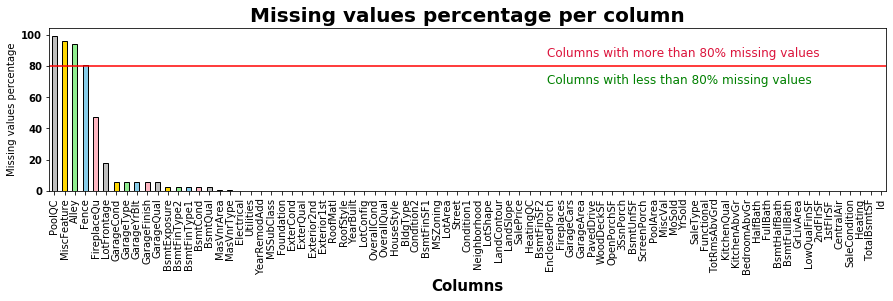

In [8]:
msv1(df_train, 80, color=('silver', 'gold', 'lightgreen', 'skyblue', 'lightpink'))


In [9]:
# drop columns (features ) with > 80% missing vales
c=df_train.dropna(thresh=len(df_train)*0.8, axis=1)
print('I dropped ',df_train.shape[1]-c.shape[1], ' features in the train set')

I dropped  5  features in the train set


In [10]:
d=[]
for i in df_train.columns:
    if i in c.columns:
        continue
    else:
        d.append(i) 
d

['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature']

In [11]:
allna = (c.isnull().sum() / len(c))*100
allna = allna.drop(allna[allna == 0].index).sort_values()

def msv2(data, width=12, height=8, color=('silver', 'gold','lightgreen','skyblue','lightpink'), edgecolor='black'):
    """
    SOURCE: https://www.kaggle.com/amiiiney/price-prediction-regularization-stacking
    """
    fig, ax = plt.subplots(figsize=(width, height))

    allna = (data.isnull().sum() / len(data))*100
    tightout= 0.008*max(allna)
    allna = allna.drop(allna[allna == 0].index).sort_values().reset_index()
    mn= ax.barh(allna.iloc[:,0], allna.iloc[:,1], color=color, edgecolor=edgecolor)
    ax.set_title('Missing values percentage per column', fontsize=15, weight='bold' )
    ax.set_xlabel('Percentage', weight='bold', size=15)
    ax.set_ylabel('Features ', weight='bold')
    plt.yticks(weight='bold')
    plt.xticks(weight='bold')
    for i in ax.patches:
        ax.text(i.get_width()+ tightout, i.get_y()+0.1, str(round((i.get_width()), 2))+'%',
            fontsize=10, fontweight='bold', color='grey')
    return plt.show()

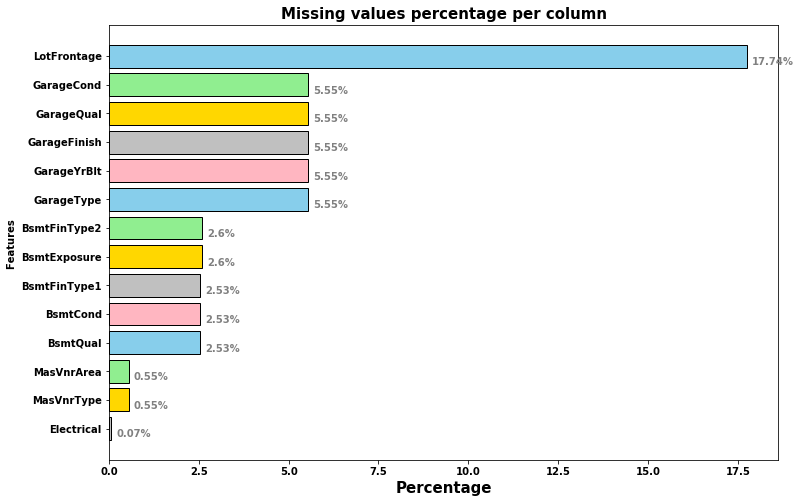

In [12]:
msv2(c)

In [13]:
#for all the NAs assign to a varriable NA
NA=c[allna.index.to_list()]

In [14]:
NAcat=NA.select_dtypes(include='object')
NAnum=NA.select_dtypes(exclude='object')
print('We have :',NAcat.shape[1],'categorical features with missing values')
print('We have :',NAnum.shape[1],'numerical features with missing values')

We have : 11 categorical features with missing values
We have : 3 numerical features with missing values


### Numerical features:

In [15]:
NAnum.head()

,MasVnrArea,GarageYrBlt,LotFrontage
0,196.0,2003.0,65.0
1,0.0,1976.0,80.0
2,162.0,2001.0,68.0
3,0.0,1998.0,60.0
4,350.0,2000.0,84.0


In [16]:
NANUM= NAnum.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

NANUM = NANUM.style.background_gradient(cmap=cm)
NANUM


,MasVnrArea,GarageYrBlt,LotFrontage
0,8,81,259


In [17]:
#MasVnrArea: Masonry veneer area in square feet, the missing data means no veneer so we fill with 0
c['MasVnrArea']=c.MasVnrArea.fillna(0)
#LotFrontage has 16% missing values. We fill with the median
c['LotFrontage']=c.LotFrontage.fillna(c.LotFrontage.median())
#GarageYrBlt:  Year garage was built, we fill the gaps with the median: 1980
c['GarageYrBlt']=c["GarageYrBlt"].fillna(1980)
#For the rest of the columns: Bathroom, half bathroom, basement related columns and garage related columns:
#We will fill with 0s because they just mean that the hosue doesn't have a basement, bathrooms or a garage

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

In [18]:
bb=c[allna.index.to_list()]
nan=bb.select_dtypes(exclude='object')
N= nan.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

N= N.style.background_gradient(cmap=cm)
N

,MasVnrArea,GarageYrBlt,LotFrontage
0,0,0,0


### Categorical features:

In [19]:
NAcat.head()

,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,SBrkr,BrkFace,Gd,TA,GLQ,No,Unf,Attchd,RFn,TA,TA
1,SBrkr,None,Gd,TA,ALQ,Gd,Unf,Attchd,RFn,TA,TA
2,SBrkr,BrkFace,Gd,TA,GLQ,Mn,Unf,Attchd,RFn,TA,TA
3,SBrkr,None,TA,Gd,ALQ,No,Unf,Detchd,Unf,TA,TA
4,SBrkr,BrkFace,Gd,TA,GLQ,Av,Unf,Attchd,RFn,TA,TA


Number of missing values per column in Categorical features after the drop missing values with > 80%

In [20]:
NAcat1= NAcat.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

NAcat1 = NAcat1.style.background_gradient(cmap=cm)
NAcat1


,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,1,8,37,37,37,38,38,81,81,81,81


In [21]:
fill_cols = ['Electrical', 'SaleType', 'KitchenQual', 'Exterior1st',
             'Exterior2nd', 'Functional', 'Utilities', 'MSZoning']

for col in c[fill_cols]:
    c[col] = c[col].fillna(method='ffill')


/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [22]:
#we will just 'None' in categorical features
#Categorical missing values
NAcols=c.columns
for col in NAcols:
    if c[col].dtype == "object":
        c[col] = c[col].fillna("None")

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [23]:
#we will just fill 0s in the numerical features 
#Numerical missing values
for col in NAcols:
    if c[col].dtype != "object":
        c[col]= c[col].fillna(0)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [24]:
c.isnull().sum().sort_values(ascending=False).head()

SalePrice      0
ExterCond      0
RoofStyle      0
RoofMatl       0
Exterior1st    0
dtype: int64

In [25]:
FillNA=c[allna.index.to_list()]



FillNAcat=FillNA.select_dtypes(include='object')

FC= FillNAcat.isnull().sum().to_frame().sort_values(by=[0]).T
cm = sns.light_palette("lime", as_cmap=True)

FC= FC.style.background_gradient(cmap=cm)
FC

,Electrical,MasVnrType,BsmtQual,BsmtCond,BsmtFinType1,BsmtExposure,BsmtFinType2,GarageType,GarageFinish,GarageQual,GarageCond
0,0,0,0,0,0,0,0,0,0,0,0


,SalePrice
count,1460.000000
mean,180921.195890
std,79442.502883
min,34900.000000
25%,129975.000000
50%,163000.000000
75%,214000.000000
max,755000.000000


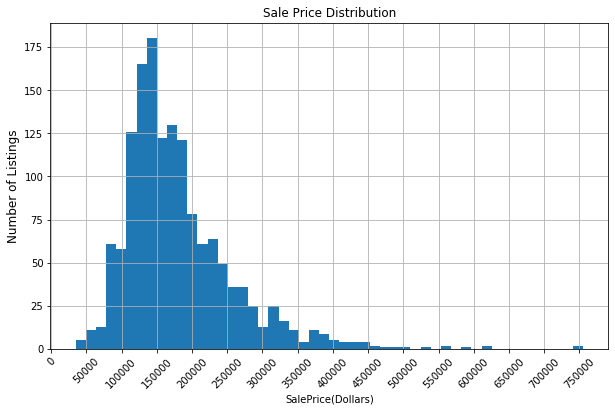

In [26]:

fig = plt.figure(figsize=(10,6))
ax = c['SalePrice'].hist(bins=50)
# ax.set_ylabel('Number of Passengers')
plt.xticks(np.arange(0,800000,50000),rotation=45,fontsize=10)
ax.set_xlabel('SalePrice(Dollars)',fontsize=10)
ax.set_ylabel('Number of Listings',fontsize=12)
ax.set_title('Sale Price Distribution',fontsize=12)
pd.DataFrame(c['SalePrice'].describe())

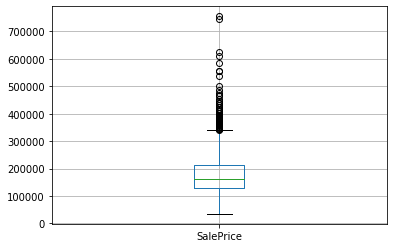

In [27]:
c.boxplot(column= 'SalePrice')


In the brief description of the whole dataset, we can see in the 1460 houses, the mean value of the sale prices is 180921 USD, while the cheapest one is only 34900 USD and the most expensive one is 757000 USD

In [28]:
# df = df.fillna(0)

### Feature Engineering

In [29]:
df=c

Created an age feature TrueYear saying that considering if a building is remmodeled, the TrueYear feature is taken as the actual year of construction we would represent a more acurate relationship between the SalePrice and Yearbuilt

In [30]:
# # created age column which is how old the building is
# df['Age'] = df['YrSold'] - df['YearBuilt']

In [31]:
# #year since remodeled 
# df['SinceRemod'] = df['YrSold'] - df['YearRemodAdd']

In [32]:
#true age is since when last remodel else sice when built
df['TrueYear'] = np.where(df['YearRemodAdd'] > 0, df['YearRemodAdd'], df['YearBuilt'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
pd.set_option('display.max_columns', 50)

#### Total Area and Bathroom  features

I created a feature total area an addition of all the measurements of the building  and also a bathroom an addition of the bathroom feaures

In [34]:
#create feature total area an addition of all the measurements of the building 
df['TotalArea'] =df['TotalBsmtSF'] + df['1stFlrSF'] + df['2ndFlrSF'] + df['GrLivArea'] +df['GarageArea']

# df['Bathrooms'] = df['FullBath'] + df['HalfBath']*0.5 

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [35]:
df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,...,TotRmsAbvGrd,Functional,Fireplaces,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice,TrueYear,TotalArea
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,8,Typ,0,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,0,2,2008,WD,Normal,208500,2003,4824
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,...,6,Typ,1,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,0,5,2007,WD,Normal,181500,1976,4246
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,6,Typ,1,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,0,9,2008,WD,Normal,223500,2002,5100
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,...,7,Typ,1,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,0,2,2006,WD,Abnorml,140000,1970,4832
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,...,9,Typ,1,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,0,12,2008,WD,Normal,250000,2000,6377


In [36]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
TotalArea        0.801018
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
TrueYear         0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
GarageYrBlt      0.466754
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorc

Text(0.5, 1, 'Column pairs with correlation coefficient higher than 0.7')

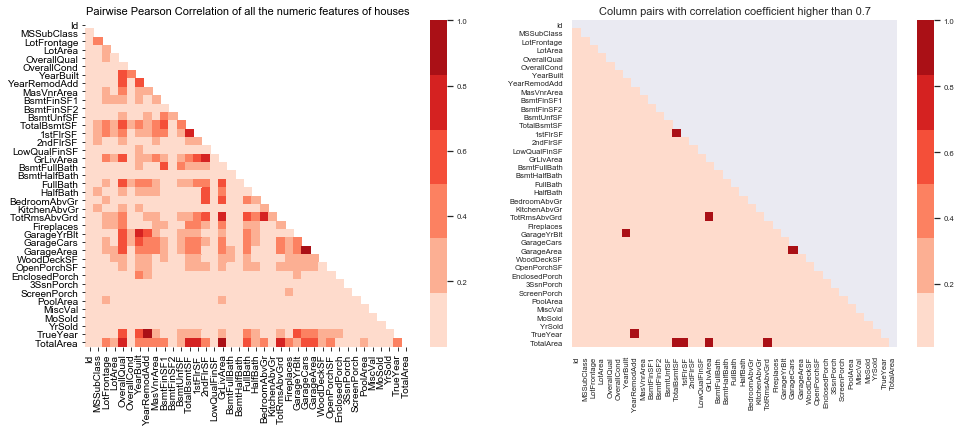

In [37]:
#drop target varribale

df_no_SP = df.drop('SalePrice',axis=1)
corr_all = abs(df_no_SP.corr())


# Thresholding the correlations larger than 0.7 (or-0.7) 
corr_all_true = corr_all>0.7 
corr_all_true = corr_all_true

corr_dict = {}
for column in corr_all_true:
    corr_list = corr_all_true[column][corr_all_true[column]==True].index.tolist()
    corr_dict[column] = corr_list

# pprint.pprint(corr_dict)

# create custom color map
cmap = sns.color_palette("Reds")
fig1 = plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
# Generate a mask for the upper triangle
sns.set(font_scale=0.7)
mask = np.zeros_like(corr_all, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_all, mask=mask, cmap=cmap,
          xticklabels=corr_all.columns.values,
          yticklabels=corr_all.columns.values)
plt.title('Pairwise Pearson Correlation of all the numeric features of houses',fontsize=11)


# fig2 = plt.figure()
plt.subplot(1,2,2)
sns.heatmap(corr_all_true,mask=mask,cmap=cmap,
           xticklabels=corr_all_true.columns.values,
           yticklabels=corr_all_true.columns.values,
           vmin=0.01,vmax=1)

plt.title('Column pairs with correlation coefficient higher than 0.7',fontsize=11)

In [38]:

# Build a list of all the numeric column names for our dataframe, except SalePrice
num_cols_all = list(corr_all.columns)
# print(cols)
cols = num_cols_all

# See how many columns there are at first
len_1=len(num_cols_all)
removed_features=[]
# In the correlation dictionary, if the key is still in the columns_list, remove the items in the value from the columns_list that is not equal
# to the key itself.
for key, value in corr_dict.items():
    if key in cols:
        for feature in value:
            if (feature in cols) & (feature != key and feature != 'TrueYear'):#keep True age
                cols.remove(feature)
                removed_features.append(feature)
# Take a look how many features (columns) are removed from the last step.
len_2 = len(cols)

df = df.drop(removed_features,axis=1)
print('There are',len(removed_features),'features removed for high pairwise correlation:\n\n',removed_features)

There are 6 features removed for high pairwise correlation:

 ['GarageYrBlt', '1stFlrSF', 'TotalArea', 'TotRmsAbvGrd', 'GarageArea', 'YearRemodAdd']


#### Run pairwise pearson correlation plot to confirm we have removed all the features with high pair-correlation


Text(0.5, 1, 'Pairwise Pearson Correlation of Remaining Numeric Features of Houses')

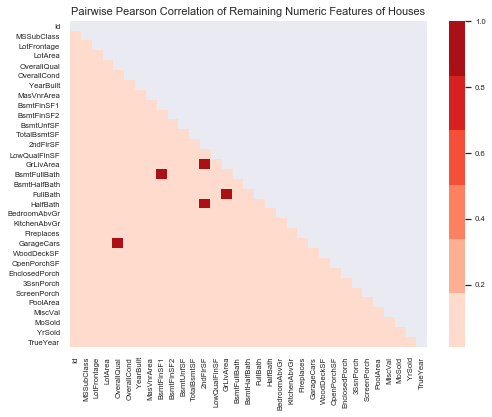

In [39]:

# select the dependent columns from previous DataFrame with no SalePrice, calculate the cross correlation, setup same threshold
# as before, and plot the heat map for the ture-false map. 
corr_no_repeat = abs(df[cols].corr())>0.6
# corr_no_repeat = abs(df[cols].corr())
fig3 = plt.figure(figsize=(8,6))
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 10}
cmap = sns.color_palette("Reds")
# Generate a mask for the upper triangle
mask = np.zeros_like(corr_no_repeat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
sns.heatmap(corr_no_repeat, mask=mask,cmap=cmap,
          xticklabels=corr_no_repeat.columns.values,
          yticklabels=corr_no_repeat.columns.values,
          vmin=0.01,vmax=1)
sns.set(font_scale=1.3)
plt.title('Pairwise Pearson Correlation of Remaining Numeric Features of Houses',fontsize=11)

#### Study the correlation between the top related numerical features and SalePrice

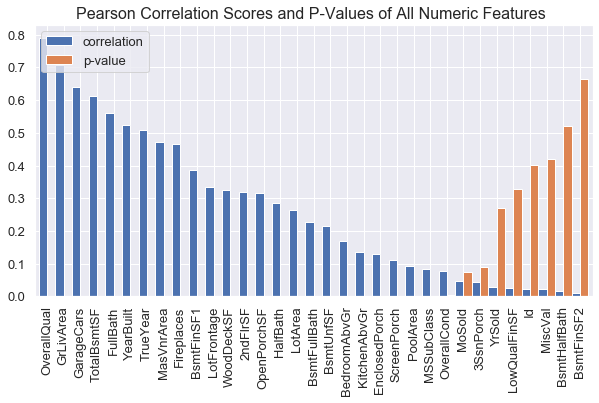

In [40]:

# Rebuild the numeric dataframe with SalePrice
num_cols = cols
num_df = df[num_cols]

pearson_dict={}
for col in num_df.columns:
    pearson_dict[col] = stats.pearsonr(df[col], df['SalePrice'])
# pprint.pprint(pear_dict)
pearson_df = pd.DataFrame(pearson_dict,index=['correlation','p-value'])
pearson_df=pearson_df.T.abs().sort_values(['correlation','p-value'],ascending=[False,True])
pearson_df.plot.bar(figsize=(10,5),fontsize=13,width=1)
plt.title('Pearson Correlation Scores and P-Values of All Numeric Features ',fontsize=16)
plt.legend(fontsize=13,loc = 2)

 #### The plot  above shows the correlation coefficients of features VS saleprice, from high to low for all the features.
And the p-value roughly indicates the probability of an uncorrelated system producing datasets that have a Pearson correlation at least as extreme as the one computed from these datasets, which means the lower p-value is, the better correlation is.



In [41]:
df.corrwith(df['SalePrice']).sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
TotalBsmtSF      0.613581
FullBath         0.560664
YearBuilt        0.522897
TrueYear         0.507101
MasVnrArea       0.472614
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.334771
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
dtype: float64

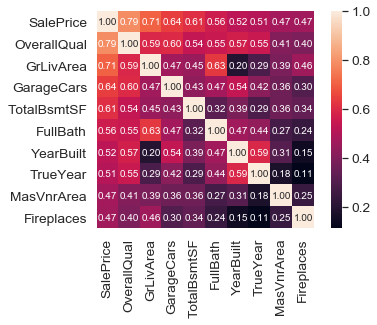

In [42]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = df.corr().nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

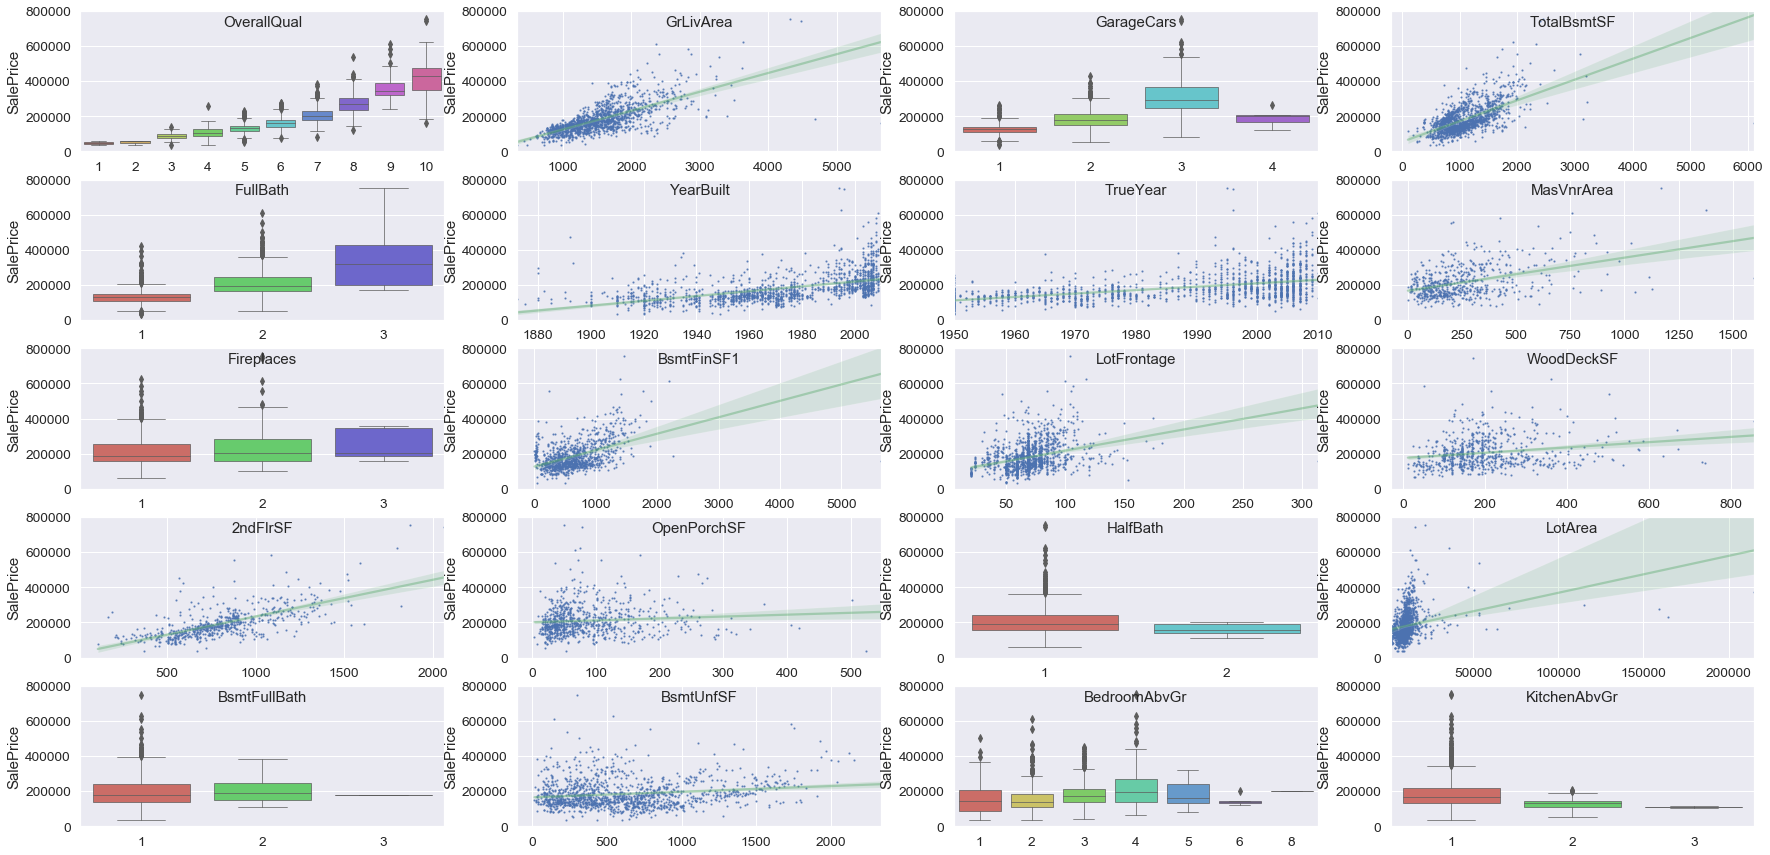

In [43]:

plt.fontsize=5
plt.figure(figsize=(30,15))
for i in range(20):
    name = pearson_df.index[i]
    plt.subplot(5,4,i+1)
    plt.ylim(0,800000)
    if df[name].unique().size>10:# nummeric features have more range
        sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4})
    else:
#         sns.regplot(x=name, y="SalePrice", data=df[df[name]>0],scatter_kws={"s": 1.5,'alpha':0.7},line_kws={'color':'g','alpha':0.4},x_estimator=np.mean)
        sns.boxplot(x=name, y='SalePrice',data=df[df[name]>0],palette='hls',linewidth=0.7)
    plt.title(name,y=0.85)
    plt.xlabel('')


### A closer look at some of the numeric features

- GarageArea (Size of garage in square feet)
- TotalBsmtSF (Total square feet of basement area)
- YearBuilt ( Original Constrbbuction Data)
- TrueYear (Engineered Feature)

#### GrLivArea (Size of garage in square feet)

Text(0.5, 0, 'Above grade (ground) living area square feet')

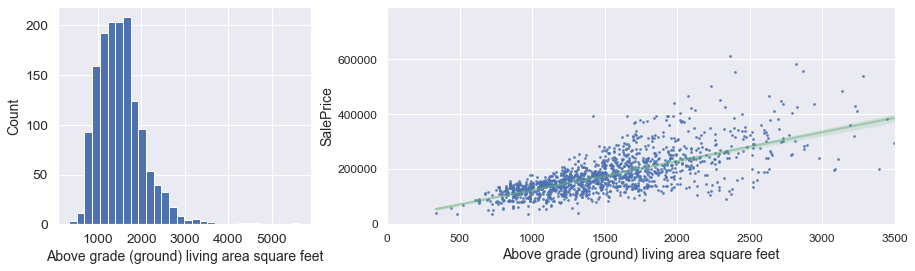

In [44]:
from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['GrLivArea'],bins=30)
plt.xlabel('Above grade (ground) living area square feet',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])

sns.regplot(x='GrLivArea', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,3500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Above grade (ground) living area square feet',fontsize=14)




The histogram above shows the distribution of the GrLivArea. And the scatter plot with regression line shows that there is clear correlation between GrLivArea and SalePrice.

In [62]:
# df['log_GrLivArea']= (df['GrLivArea']).apply(lambda x:np.log(x))
# fig4, ax = plt.subplots(figsize=(5,5)) 
    
# sns.scatterplot(data=df, y=df['SalePrice'], x=df['log_GrLivArea'])

####  TotalBsmtSF (Total square feet of basement area)

Text(0.5, 0, 'Total square feet of basement area')

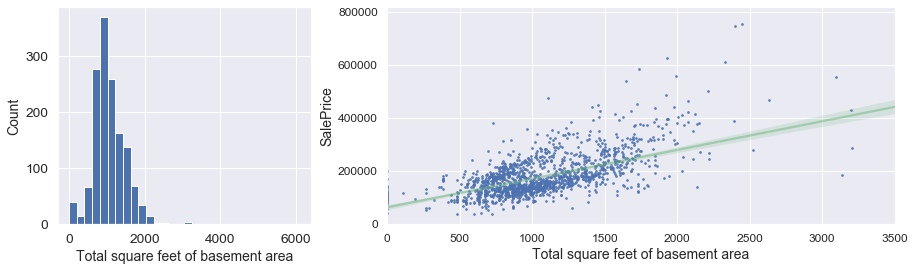

In [45]:

from matplotlib import gridspec
plt.figure(figsize=(15,4))
gs = gridspec.GridSpec(1, 2, width_ratios=[1, 2]) 
plt.subplot(gs[0])
plt.hist(df['TotalBsmtSF'],bins=30)
plt.xlabel('Total square feet of basement area',fontsize=14)
plt.ylabel('Count',fontsize=14)

plt.subplot(gs[1])

sns.regplot(x='TotalBsmtSF', y="SalePrice",data=df,robust=True,scatter_kws={"s": 3},line_kws={'color':'g','alpha':0.4})
plt.xlim([0,3500])
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('SalePrice',fontsize=14)
plt.xlabel('Total square feet of basement area',fontsize=14)

The histogram above shows the distribution of the TotalBsmtSF. And the scatter plot with regression line shows that there is clear correlation between TotalBsmtSF and SalePrice.

#### YearBuilt (Original Construction Data)

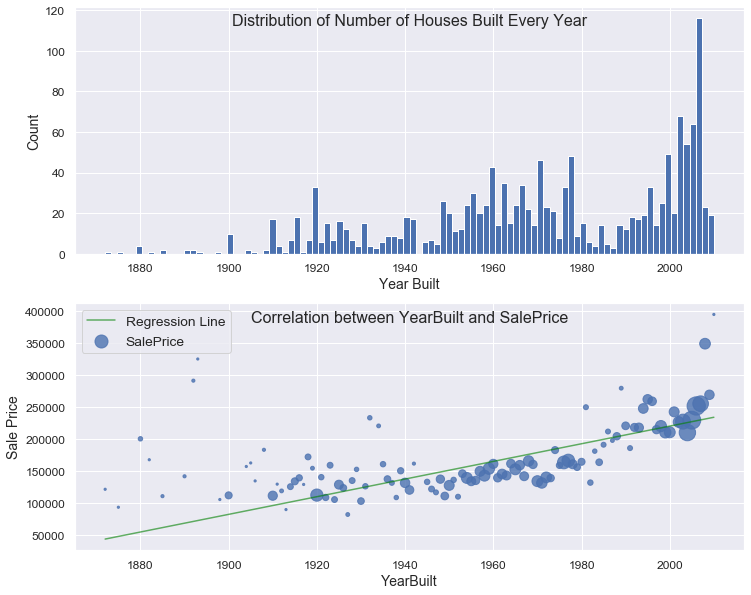

In [46]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.YearBuilt,bins=100)
YearMean=df.groupby(['YearBuilt']).SalePrice.mean()
YearSize=df.groupby(['YearBuilt']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Year Built',fontsize=14)
plt.title('Distribution of Number of Houses Built Every Year',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)

fit = np.polyfit(df.YearBuilt,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('YearBuilt',fontsize=14)
plt.title('Correlation between YearBuilt and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])

There seems to be a general linear relationship between Year built and Sale price, but some what might seem to be old building are still going for above average


#### TrueYear (Engineered Feature)

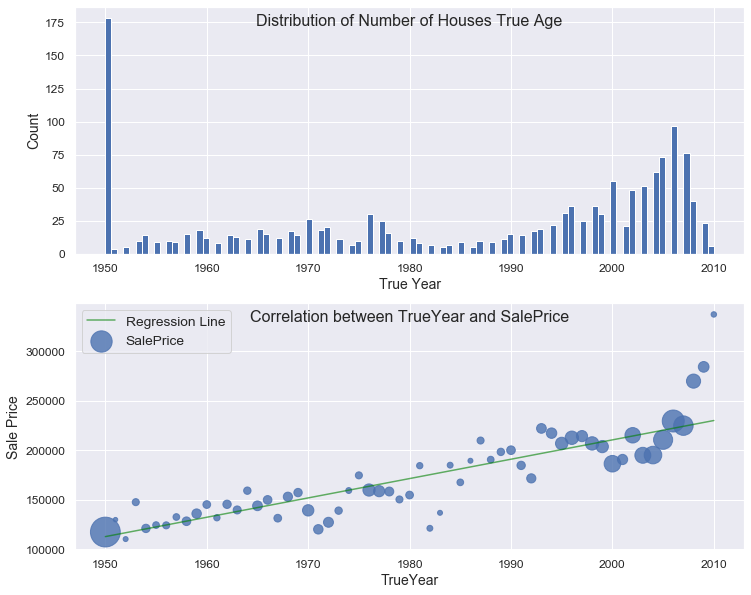

In [47]:
fig1 = plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.TrueYear,bins=100)
YearMean=df.groupby(['TrueYear']).SalePrice.mean()
YearSize=df.groupby(['TrueYear']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('True Year',fontsize=14)
plt.title('Distribution of Number of Houses True Age',fontsize=16,y=0.9)

plt.subplot(2,1,2)
plt.scatter(YearMean.index,YearMean,s=YearSize*5,alpha=0.8)
# the regression line is created with all the original SalePrice, not the year-mean value
fit = np.polyfit(df.TrueYear,df.SalePrice,deg=1)
plt.plot(YearMean.index, fit[0] * YearMean.index + fit[1], color='green',alpha=0.6)
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('TrueYear',fontsize=14)
plt.title('Correlation between TrueYear and SalePrice',fontsize=16,y=0.9)
plt.legend(['Regression Line','SalePrice'])

There is more of a linear relationship between TrueYear and SalesPrice which is expected.Because accounting for rennovation in the houses would explain why some old houses still went for high prices

In [48]:
lm= ['January','February','March','April','May','June','July','August','September','October','November','December']

Text(0.5, 0.9, 'Distribution of Number of Houses sales across months')

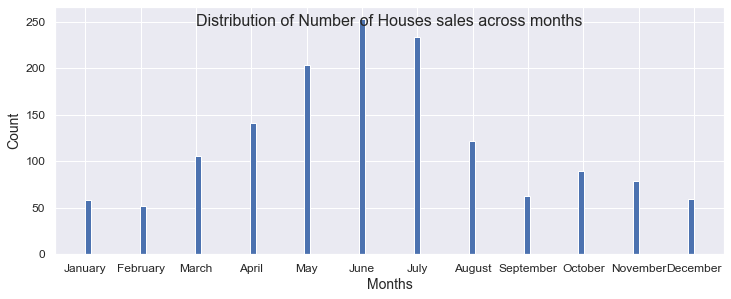

In [49]:
fig1= plt.figure(figsize=(12,10))

plt.subplot(2,1,1)
plt.hist(df.MoSold,bins=100)
month=df.groupby(['MoSold']).SalePrice.count()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.xticks( [ 1, 2,3, 4,5,6,7,8,9,10,11,12],lm, rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Months',fontsize=14)
plt.title('Distribution of Number of Houses sales across months',fontsize=16,y=0.9)


June and july over the years seem to be the highest selling months

### Correlation between the categorical features and SalePrice

- prepare the categorical features
- rate the correlations of each features VS SalePrice and save in DataFrame
- Sort the features by r_2 scores from high to low. Show the result in a table and a barplot below.

In [50]:
num_cols

['Id',
 'MSSubClass',
 'LotFrontage',
 'LotArea',
 'OverallQual',
 'OverallCond',
 'YearBuilt',
 'MasVnrArea',
 'BsmtFinSF1',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'TotalBsmtSF',
 '2ndFlrSF',
 'LowQualFinSF',
 'GrLivArea',
 'BsmtFullBath',
 'BsmtHalfBath',
 'FullBath',
 'HalfBath',
 'BedroomAbvGr',
 'KitchenAbvGr',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'MoSold',
 'YrSold',
 'TrueYear']

In [51]:
from statsmodels.formula.api import ols

############### prepare categorical features#################### 
# cat_df: categorical data from original df
cat_df = df.drop(num_cols,axis=1).drop('SalePrice',axis=1)

############### Rate the correlation with R_2 sccore############
features_R = {}
for feature in cat_df.columns.values.tolist():
    model = ols('SalePrice ~'+feature, df).fit()
    features_R[feature] = model.rsquared

############### Sort the features by r_2 scores ################
r_df = pd.DataFrame(list(features_R.items()),columns=['features','R_squared']).sort_values(by=['R_squared'],ascending=False)
r_df.index = r_df['features']
r_df = r_df.drop('features',axis=1)

In [52]:

r_df.T

features,Neighborhood,ExterQual,BsmtQual,KitchenQual,GarageFinish,Foundation,GarageType,BsmtFinType1,HeatingQC,MasVnrType,Exterior2nd,Exterior1st,BsmtExposure,SaleType,SaleCondition,MSZoning,HouseStyle,GarageQual,GarageCond,LotShape,CentralAir,Electrical,RoofStyle,PavedDrive,BsmtCond,BldgType,Condition1,RoofMatl,BsmtFinType2,LandContour,ExterCond,LotConfig,Functional,Heating,Condition2,LandSlope,Street,Utilities
R_squared,0.545575,0.477388,0.464994,0.456599,0.305874,0.256368,0.249204,0.21081,0.1955,0.183277,0.15383,0.152773,0.1495,0.137287,0.135497,0.10756,0.086313,0.081421,0.081346,0.076376,0.063166,0.059651,0.057697,0.05454,0.051396,0.034534,0.032631,0.031413,0.030294,0.025794,0.023618,0.021019,0.01648,0.014437,0.009899,0.002682,0.001684,0.000205


<Figure size 936x576 with 0 Axes>

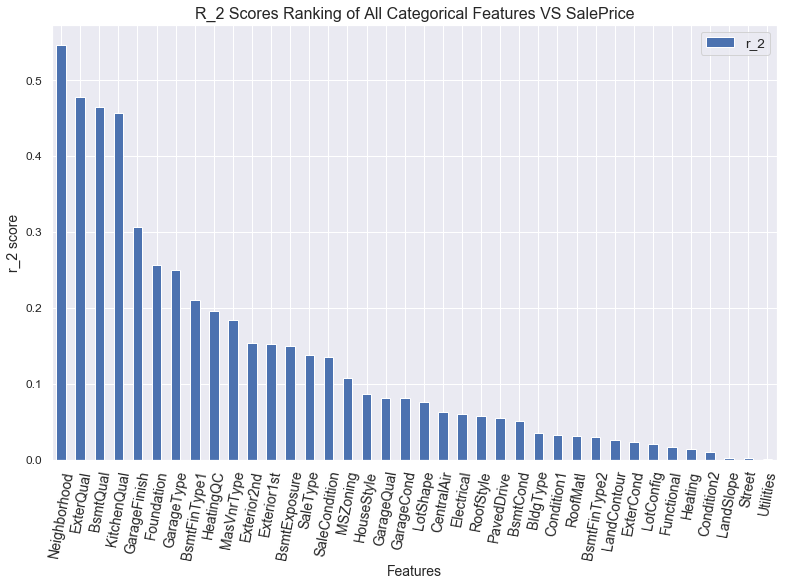

In [53]:
fig = plt.figure(figsize=(13,8))
# plt.bar(r_df.index,r_df.R_squared)
r_df.plot.bar(figsize=(13,8))
plt.title('R_2 Scores Ranking of All Categorical Features VS SalePrice',fontsize=16)
plt.yticks(fontsize=12)
plt.xticks(rotation=80,fontsize=14)
plt.ylabel('r_2 score',fontsize=14)
plt.xlabel('Features',fontsize=14)
plt.legend(['r_2'])


#### Take a closer look at some top ranked features

- Neighborhood(Physical locations within Ames city limits)
- ExterQual( Exterior material quality)
- BsmtQual(Evaluates the height of the basement)

Text(0.5, 0.98, '')

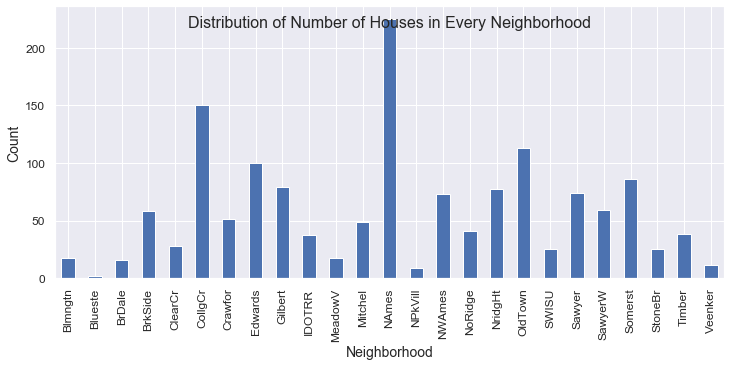

<Figure size 864x360 with 0 Axes>

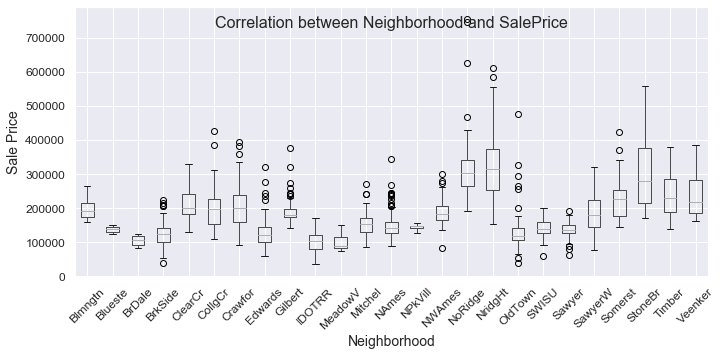

In [54]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('Neighborhood').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Count',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Distribution of Number of Houses in Every Neighborhood',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='Neighborhood',figsize=(11,5),rot=45)
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('Neighborhood',fontsize=14)
plt.title('Correlation between Neighborhood and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

Text(0.5, 0.98, '')

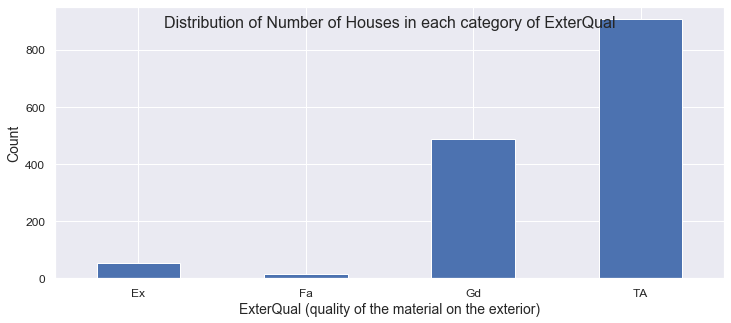

<Figure size 864x360 with 0 Axes>

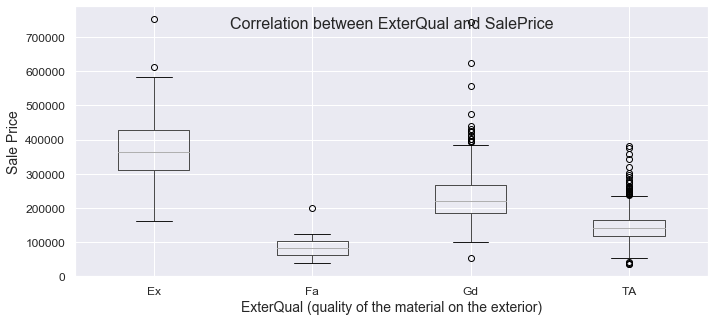

In [55]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('ExterQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of ExterQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='ExterQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('ExterQual (quality of the material on the exterior)',fontsize=14)
plt.title('Correlation between ExterQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

From the plots above, when it came to Fa (fair) quality of material on the exterior it seems to be compromisable

#### BsmtQual:

Text(0.5, 0.98, '')

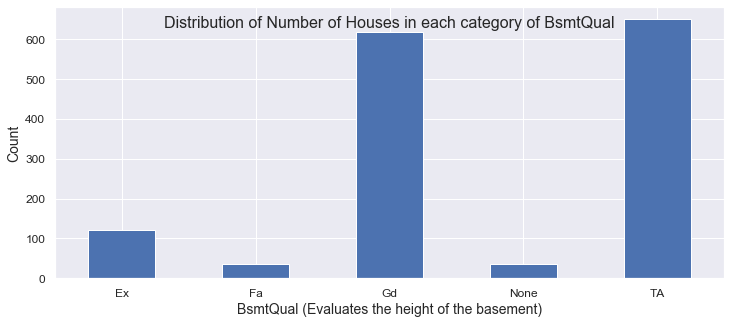

<Figure size 864x360 with 0 Axes>

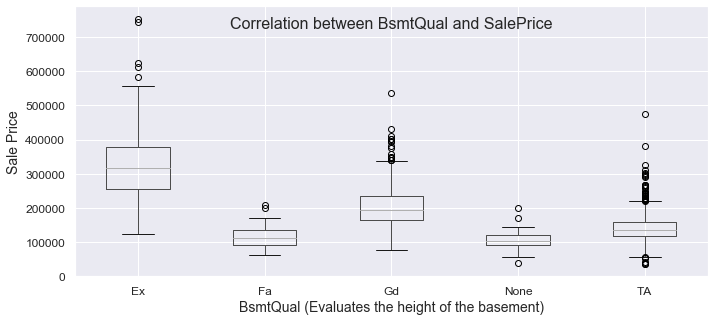

In [56]:
fig1 = plt.figure(figsize=(12,5))

ax = df.groupby('BsmtQual').count().Id.plot.bar()
# ax = df.groupby('Neighborhood').count().reset_index('count').sort_values('count').Id.plot.bar()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12,rotation=0)
plt.ylabel('Count',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Distribution of Number of Houses in each category of BsmtQual',fontsize=16,y=0.9)

fig2 = plt.figure(figsize=(12,5))
ax = df.boxplot(column='SalePrice',by='BsmtQual',figsize=(11,5))
# ax = df.groupby('Neighborhood').SalePrice.plot.box()
plt.yticks(fontsize=12)
plt.xticks(fontsize=12)
plt.ylabel('Sale Price',fontsize=14)
plt.xlabel('BsmtQual (Evaluates the height of the basement)',fontsize=14)
plt.title('Correlation between BsmtQual and SalePrice',fontsize=16,y=0.9)
plt.suptitle('')

From the plots above, it is obvious that houses in some BsmtQual have higher price, and some have lower price.

### High correlated features:

Considering correlation(or r_squared)>0.05 as significant, the top numerical features and top categorical features are listed below, and we are going to use these useful_features for the following model training.

In [57]:
# absolute values >0.05
num_top_features = pearson_df[abs(pearson_df['correlation'])>0.05].index.values.tolist()
cat_top_features = r_df[abs(r_df['R_squared'])>0.05].index.values.tolist()
useful_features = num_top_features+cat_top_features
print(len(num_top_features),'numerical features:\n',num_top_features,'\n')
print(len(cat_top_features),'catigorical features:\n',cat_top_features)

25 numerical features:
 ['OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'TrueYear', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', '2ndFlrSF', 'OpenPorchSF', 'HalfBath', 'LotArea', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', 'ScreenPorch', 'PoolArea', 'MSSubClass', 'OverallCond'] 

25 catigorical features:
 ['Neighborhood', 'ExterQual', 'BsmtQual', 'KitchenQual', 'GarageFinish', 'Foundation', 'GarageType', 'BsmtFinType1', 'HeatingQC', 'MasVnrType', 'Exterior2nd', 'Exterior1st', 'BsmtExposure', 'SaleType', 'SaleCondition', 'MSZoning', 'HouseStyle', 'GarageQual', 'GarageCond', 'LotShape', 'CentralAir', 'Electrical', 'RoofStyle', 'PavedDrive', 'BsmtCond']


In [58]:
# import numpy as np
# from sklearn.model_selection import train_test_split
# def preprocess_features(X):
#     # Initialize new output DataFrame(empty)
#     output = pd.DataFrame(index = X.index)
    
#     # Investigate each feature column for the data
#     for col, col_data in X.iteritems():
#         #print(col,col_data)

#         # If data type is categorical, convert to dummy variables
#         if col_data.dtype == object:
#             col_data = pd.get_dummies(col_data, prefix = col)  
        
#         # Collect the revised columns
#         output = output.join(col_data)
    
#     return output



In [ ]:

# # Keep only the useful features in X
# df_featured = df[useful_features]
# y = np.log(df.SalePrice)
# X = df_featured.loc[:,df_featured.columns != 'SalePrice']

# # X_all is df all numeric, and no "SalePrice"
# X_all = preprocess_features(X)
# X_all.info()

# # Split the targets into training/testing sets
# X_train, X_test, y_train, y_test = train_test_split(X_all, y, test_size=0.20, random_state=42)

### A closer look at the target variable (SalePrice)

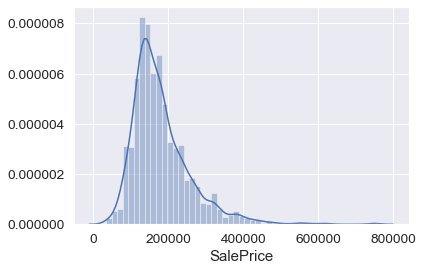

In [64]:
# Histogram
sns.distplot(df.SalePrice);

In [65]:
#skewness and kurtosis
print("Skewness: %f" % df_train['SalePrice'].skew())
print("Kurtosis: %f" % df_train['SalePrice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


- SalePrice is not normal distributed
- Have positive skewness

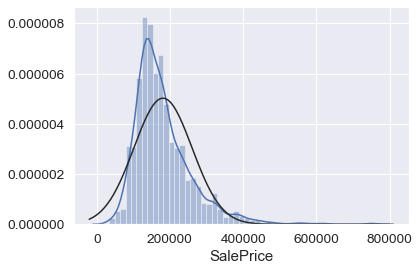

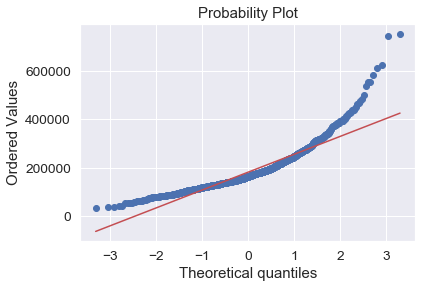

In [67]:
#histogram and normal probability plot
sns.distplot(df['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(df['SalePrice'], plot=plt)

As seen above, 'SalePrice' is not normally distributed. We can solve this with simple log transformation.



In [69]:
#log transform saleprice
df.SalePrice = np.log(df.SalePrice)

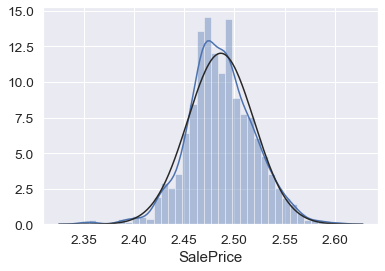

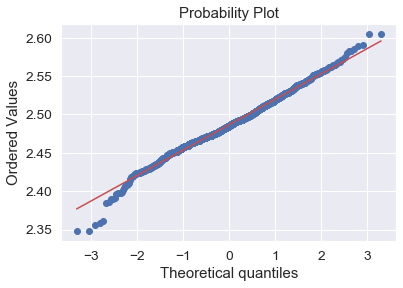

In [71]:
# histogram and normal probability plot
sns.distplot(df.SalePrice, fit=norm);
fig = plt.figure()
res = stats.probplot(df.SalePrice, plot=plt)

In [74]:
len(df[useful_features].columns)

50

### Dummy variables for categorical variables

In [75]:
df2=df[useful_features]

In [76]:
df2=pd.get_dummies(df2)

In [77]:
df2.head()

,OverallQual,GrLivArea,GarageCars,TotalBsmtSF,FullBath,YearBuilt,TrueYear,MasVnrArea,Fireplaces,BsmtFinSF1,LotFrontage,WoodDeckSF,2ndFlrSF,OpenPorchSF,HalfBath,LotArea,BsmtFullBath,BsmtUnfSF,BedroomAbvGr,KitchenAbvGr,EnclosedPorch,ScreenPorch,PoolArea,MSSubClass,OverallCond,...,LotShape_IR1,LotShape_IR2,LotShape_IR3,LotShape_Reg,CentralAir_N,CentralAir_Y,Electrical_FuseA,Electrical_FuseF,Electrical_FuseP,Electrical_Mix,Electrical_SBrkr,RoofStyle_Flat,RoofStyle_Gable,RoofStyle_Gambrel,RoofStyle_Hip,RoofStyle_Mansard,RoofStyle_Shed,PavedDrive_N,PavedDrive_P,PavedDrive_Y,BsmtCond_Fa,BsmtCond_Gd,BsmtCond_None,BsmtCond_Po,BsmtCond_TA
0,7,1710,2,856,2,2003,2003,196.0,0,706,65.0,0,854,61,1,8450,1,150,3,1,0,0,0,60,5,...,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
1,6,1262,2,1262,2,1976,1976,0.0,1,978,80.0,298,0,0,0,9600,0,284,3,1,0,0,0,20,8,...,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
2,7,1786,2,920,2,2001,2002,162.0,1,486,68.0,0,866,42,1,11250,1,434,3,1,0,0,0,60,5,...,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3,7,1717,3,756,1,1915,1970,0.0,1,216,60.0,0,756,35,0,9550,1,540,3,1,272,0,0,70,5,...,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,1,0,0,0
4,8,2198,3,1145,2,2000,2000,350.0,1,655,84.0,192,1053,84,1,14260,1,490,4,1,0,0,0,60,5,...,1,0,0,0,0,1,0,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1
